## Magnitude Demo

### Setup

In the below, we're just installing some dependencies and downloading the Magnitude file we wish to use.

In [1]:
# Install Magnitude on Colab
! (curl https://raw.githubusercontent.com/plasticityai/magnitude/master/install-colab.sh | /bin/bash 1>/dev/null 2>/dev/null)

# Download Word2Vec vectors
!curl -s http://magnitude.plasticity.ai/word2vec/medium/GoogleNews-vectors-negative300.magnitude --output vectors.magnitude

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   137  100   137    0     0    756      0 --:--:-- --:--:-- --:--:--   756


In [2]:
from pymagnitude import Magnitude

In [3]:
vectors = Magnitude('./vectors.magnitude')

## Usage in NER models

These word vectors can be used as powerful features in larger models. For example, here we can show how these word vectors can be used to build a simple Named Entity Recognition (NER) model.

The task of NER is to label named words in a sentence (i.e. proper nouns) as either Person, Organization, Location, or Miscellanious. We also want to recognize when a word is not a named entity. 

**Illustrative example:**


| English Word      | NER tag |
| ----------- | ----------- |
| Germany      | B-LOC       |
| 's   | O        |
| representative   | O        |
| to   | O        |
| the   | O        |
| European   | B-ORG        |
| Union   | I-ORG        |
| 's   | O        |
| veterinary   | O        |
| committee   | O        |
| Werner   | B-PER        |
| Zwingmann   | I-PER        |
| said   | O        |

As this is a sequencing task, let's create a simple LSTM model using just word vectors as features for training.

## Model.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

def read_conll(file_path):
    sentences = []
    cur_sent = []
    with open(file_path, 'r') as fin:
        for line in fin:
            line = line.rstrip('\n')
            if line == "":
                sentences.append(cur_sent)
                cur_sent = []
            else:
                cur_sent.append(tuple(line.split()))
    return sentences

Mounted at /content/gdrive


In [5]:
train_sents = read_conll('/content/gdrive/My Drive/data/eng.train')
test_sents = read_conll('/content/gdrive/My Drive/data/eng.testa')

categories = ["B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC", "O"]

def get_features_labels(sentences, categories):
  ohc = OneHotEncoder().fit([[i] for i in categories])
  feats = vectors.query([[word_data[0] for word_data in sent] for sent in sentences])
  labels = [ohc.transform([[word_data[-1]] for word_data in sent]).toarray().astype('float32') for sent in sentences]

  max_length = max([len(label) for label in labels])

  # padding
  for (i, j) in enumerate(labels):
      b = np.zeros([max_length, len(categories)])
      b[:len(j), :] = j
      labels[i] = b

  return feats, np.array(labels).astype('float32')
    
train_feats, train_labels = get_features_labels(train_sents, categories)
test_feats, test_labels = get_features_labels(test_sents, categories)

max_len = 113

model = tf.keras.models.Sequential([
    layers.Masking(mask_value=0.0, input_shape=(113,300)),
    layers.Bidirectional(layers.LSTM(50, return_sequences = True, name = "LSTM", recurrent_dropout=0.1)),
    layers.TimeDistributed(layers.Dense(9, activation = "softmax")) 
])

model.compile(optimizer = "Adam", loss=tf.keras.losses.CategoricalCrossentropy())
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 113, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 113, 100)         140400    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 113, 9)           909       
 ibuted)                                                         
                                                                 
Total params: 141,309
Trainable params: 141,309
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(train_feats, train_labels, batch_size = 64, epochs = 6, validation_split = 0.1)

Epoch 1/6
198/198 [==============================] - 355s 2s/step - loss: 0.0904 - val_loss: 0.0545
Epoch 2/6
198/198 [==============================] - 351s 2s/step - loss: 0.0387 - val_loss: 0.0313
Epoch 3/6
198/198 [==============================] - 348s 2s/step - loss: 0.0244 - val_loss: 0.0231
Epoch 4/6
138/198 [===================>..........] - ETA: 1:43 - loss: 0.0189

In [ ]:
y_pred = model.predict(test_feats)

print("Writing to results.txt")

# format is: word gold pred
with open("/content/gdrive/My Drive/results.txt", "w") as out:
    for (j, sent) in enumerate(test_sents): 
        for i in range(len(sent)):
            word = sent[i][0]
            gold = sent[i][-1]
            pred = categories[np.argmax(y_pred[j, i, :])]
            out.write("{}\t{}\t{}\n".format(word,gold,pred))
    out.write("\n")

After writing our results out to a file, we can run a pre-built scoring function that was used for this CoNLL NER task on our predictions. We get the following results.

```
accuracy:  85.21%;
...
ORG: precision:  24.39%; recall:  58.35%; FB1:  34.40  3210
```


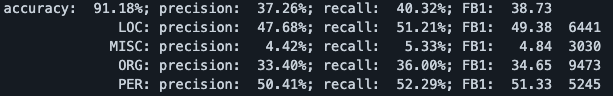

## Evaluation

Let’s try to look at some example sentences from our test set to understand how our model performs well or not. Here is a random sentence from the test set:

| Word      | True | Pred |
| ----------- | ----------- | ----------- |
|the	|O|	O|
|Swiss	|B-MISC|	I-PER|
|diplomat	|O|	O|
|who	|O|	O|
|heads	|O|	O|
|the|	O	|O|
|OSCE|	B-ORG	|B-ORG|
|Chechnya	|B-LOC|	B-LOC|
|mission	|O|	O|
|,|	O|	O|
|saying|	O|	O|
|he	|O	|O|
|was	|O|	O|
|biased	|O|	O|
|toward	|O	|O|
|Zelimkhan	|B-PER|	I-ORG|
|Yandarbiyev	|I-PER|	I-MISC|